In [1]:
# Check the RHESSI loaders in sunkit-instruments.rhessi for the summary and quicklook data
# https://github.com/sunpy/sunkit-instruments/blob/main/sunkit_instruments/rhessi/rhessi.py
# 
# It doesn't actually do very much (just loads time and rates), but does contain routines
# to return the name of the obssumm file for a particular time
# 
# Files are all in https://umbra.nascom.nasa.gov/rhessi/hessidata/metadata/catalog/
# Directory contains all of them (so slow to load)
# Files are hsi_obssumm_YYYYMMDD_XXX.fits (the XXX are a number that means something?)
#           _fullrate_ version is same but per detector instead of summed
# 
# The .txt database files contains the names of the observing summary files
# 
# 18-Dec-2024 IGH

In [2]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import astropy.units as u
import astropy.time as atime
from sunpy.time import time
from sunpy.time import parse_time
from sunpy.io._file_tools import read_file
from sunkit_instruments import rhessi

import warnings
warnings.simplefilter('ignore')

matplotlib.rcParams['font.size']=16

In [3]:
# And example file for an interesting time
obssumfile='qlook/hsi_obssumm_20061117_093.fits'

In [4]:
hdulist = read_file(obssumfile)
header, data = rhessi.parse_observing_summary_hdulist(hdulist)
header

FileHeader([('SIMPLE', True),
            ('BITPIX', 8),
            ('NAXIS', 0),
            ('EXTEND', True),
            ('DATE', '2019-11-29'),
            ('ORIGIN', 'max'),
            ('OBSERVER', 'hessiops'),
            ('TELESCOP', 'HESSI'),
            ('OBJECT', 'Sun'),
            ('DATE_OBS', '2006-11-17T00:00:00.000'),
            ('DATE_END', '2006-11-18T00:00:00.000'),
            ('COMMENT', ''),
            ('HISTORY', ''),
            ('KEYCOMMENTS',
             {'SIMPLE': 'Written by IDL:  Fri Nov 29 11:22:18 2019',
              'EXTEND': 'File contains extensions',
              'ORIGIN': 'Usually the CPU used to generate the file',
              'OBSERVER': 'Usually the name of the user who generated the',
              'TELESCOP': 'The High Energy Solar Spectroscopic Imager'})])

In [5]:
print(data.keys())
# Missing the flags from this

dict_keys(['time', 'data', 'labels'])


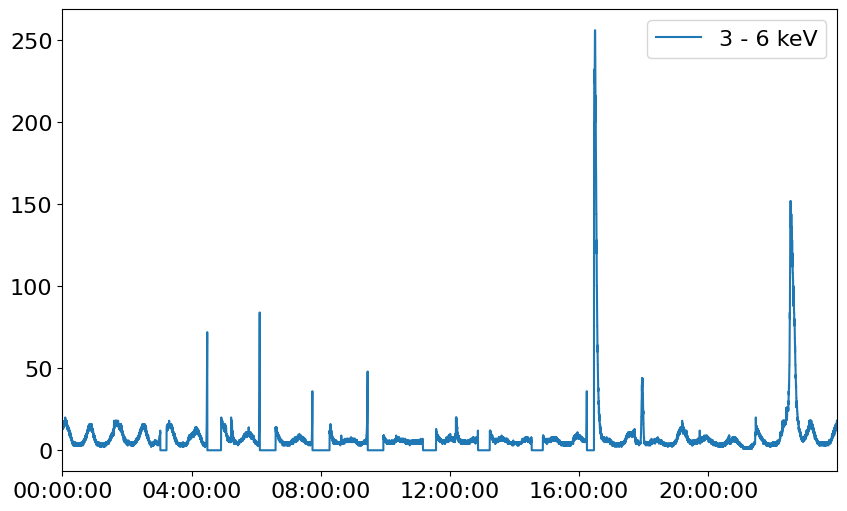

In [6]:
fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(data["time"].datetime,data["data"][:,0],label=data["labels"][0])
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=240))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax.set_xlim([data["time"][0].datetime,data["time"][-1].datetime])
plt.legend()
plt.show()

In [7]:
# As sunkit-instrument very limited just do in myself to get more info out
# Want at least the flags
oo = fits.open(obssumfile)
oo.info()

# oo here should basically be similar to what is in hudlist from earlier?
# hdulist = read_file(obssumfile)

Filename: qlook/hsi_obssumm_20061117_093.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   ()      
  1  HESSI OBS SUMMARY ID TABLE    1 BinTableHDU     15   1R x 3C   [1I, 80A, 1I]   
  2  HSI_OBSSUMMINFO    1 BinTableHDU     17   1R x 4C   [80A, 80A, 1I, 1I]   
  3  HSI_FILEDB    1 BinTableHDU     31   1R x 11C   [1I, 80A, 1J, 1J, 1D, 1D, 1I, 1J, 1E, 1E, 80A]   
  4  HESSI OBS SUMMARY RATE ID TABLE    1 BinTableHDU     18   1R x 4C   [1I, 80A, 1I, 1I]   
  5  HSI_OBSSUMMRATEINFO    1 BinTableHDU     26   1R x 8C   [1D, 18B, 1J, 1E, 1I, 10E, 80A, 720A]   
  6  HSI_OBSSUMMRATEDATA    1 BinTableHDU     11   21600R x 1C   [9B]   
  7  HESSI MOD VARIANCE ID TABLE    1 BinTableHDU     18   1R x 4C   [1I, 80A, 1I, 1I]   
  8  HSI_MODVARIANCEINFO    1 BinTableHDU     24   1R x 7C   [1D, 1J, 1E, 1I, 2E, 80A, 160A]   
  9  HSI_MODVARIANCEDATA    1 BinTableHDU     11   21600R x 1C   [2B]   
 10  HESSI EPHEMERIS ID TABLE    1 BinTableHDU

DECIMATION_WEIGHT
REAR_DEC_WEIGHT


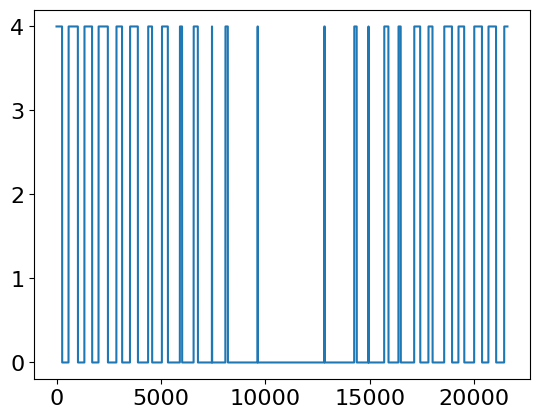

In [8]:
hdulist = read_file(obssumfile)
print(hdulist[14].data[0][4][19]) #DECIMATION_WEIGHT
print(hdulist[14].data[0][4][29]) #REAR_DEC_WEIGHT
dec_wght=[ff[19] for ff in hdulist[15].data.field("flags")]
rear_dec_wght=[ff[29] for ff in hdulist[15].data.field("flags")]
plt.plot(rear_dec_wght)

In [9]:
# Trying to work out where things are....
# What are the energy bands
eng_bands=[ff+' keV' for ff in oo[5].data[0][7]]
print(eng_bands)

# What are the flag ids and the actual flags
flag_ids=oo[14].data[0][4]
print(oo[14].data[0][4])
flags=oo[15].data.field("flags")
saa_flag=[ff[0] for ff in flags]
ecl_flag=[ff[1] for ff in flags]
flr_flag=[ff[2] for ff in flags]
att_flag=[ff[14] for ff in flags]
dec_wght=[ff[19] for ff in flags]
rear_dec_wght=[ff[29] for ff in flags]

# Need to uncompress the countrate data
comp_cr=oo[6].data["countrate"]
# This still uncorrected for decimation though....
countrate=rhessi.uncompress_countrate(comp_cr)

# And then the times
reference_time_ut = parse_time(oo[5].data.field("UT_REF")[0], format="utime")
time_interval_sec = oo[5].data.field("TIME_INTV")[0]
dim = np.array(countrate[:, 0]).size
times = parse_time(reference_time_ut) + \
    atime.TimeDelta(time_interval_sec * np.arange(dim) * u.second)


['3 - 6 keV', '6 - 12 keV', '12 - 25 keV', '25 - 50 keV', '50 - 100 keV', '100 - 300 keV', '300 - 800 keV', '800 - 7000 keV', '7000 - 15000 keV']
['SAA_FLAG' 'ECLIPSE_FLAG' 'FLARE_FLAG' 'IDPU_CONTROL' 'CRYOCOOLER_POWER'
 'COLD_PLATE_TEMP' 'FRONT_RATIO_1225' 'COLD_PLATE_SUPPLY' 'HV28_SUPPLY'
 'ACTUATOR_SUPPLY' 'FAST_HOUSEKEEPING' 'SC_TRANSMITTER' 'SC_IN_SUNLIGHT'
 'SSR_STATE' 'ATTENUATOR_STATE' 'FRONT_RATIO' 'POSSIBLE_FLARE' 'GAP_FLAG'
 'DECIMATION_ENERGY' 'DECIMATION_WEIGHT' 'MAX_DET_VS_TOT' 'NMZ_FLAG'
 'SMZ_FLAG' 'AAZ_FLAG' 'PARTICLE_FLAG' 'REAR_DEC_CHAN/128' 'PARTSTORM'
 'HLAT' 'ECLIPSE_EXT' 'REAR_DEC_WEIGHT' 'FRONTS_OFF' 'BAD_PACKETS']


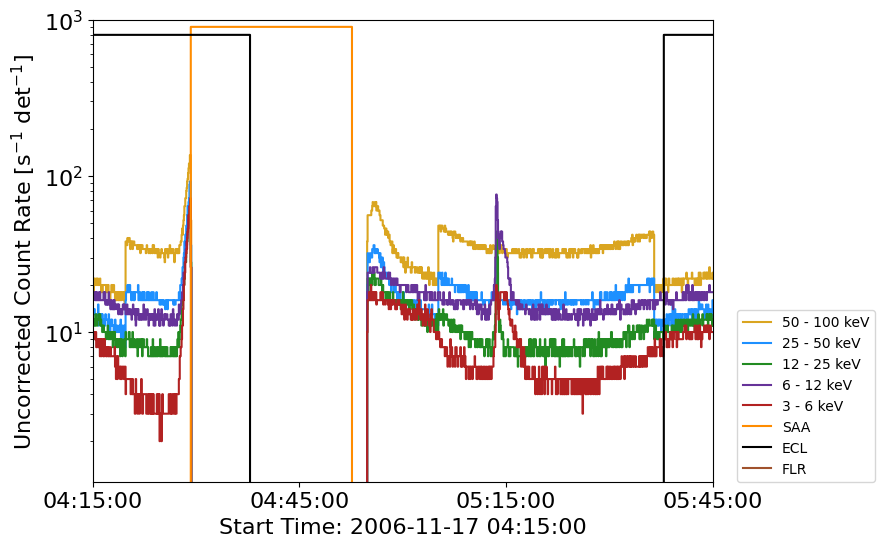

In [10]:
tr=[atime.Time("2006-11-17 04:15:00"),atime.Time("2006-11-17 05:45:00")]
fig,ax = plt.subplots(figsize=(8, 6))
plt.step(times.datetime, countrate[:,4], label=eng_bands[4], where='post',color='goldenrod')
plt.step(times.datetime, countrate[:,3], label=eng_bands[3], where='post',color='dodgerblue')
plt.step(times.datetime, countrate[:,2], label=eng_bands[2], where='post',color='forestgreen')
plt.step(times.datetime, countrate[:,1], label=eng_bands[1], where='post',color='rebeccapurple')
plt.step(times.datetime, countrate[:,0], label=eng_bands[0], where='post',color='firebrick')
ax.set_yscale('log')
ax.set_ylim([1.1,1e3])
ax.set_xlabel('Start Time: '+ tr[0].iso[:-4])
ax.set_ylabel('Uncorrected Count Rate [s$^{-1}$ det$^{-1}$]')
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax.set_xlim([tr[0].datetime,tr[1].datetime])
plt.plot(times.datetime,np.array(saa_flag)*9e2,label='SAA',color='darkorange')
plt.plot(times.datetime,np.array(ecl_flag)*8e2,label='ECL',color='black')
plt.plot(times.datetime,np.array(flr_flag)*7e2,label='FLR',color='sienna')
plt.legend(loc=(1.04,0), prop={'size': 10})
plt.show()

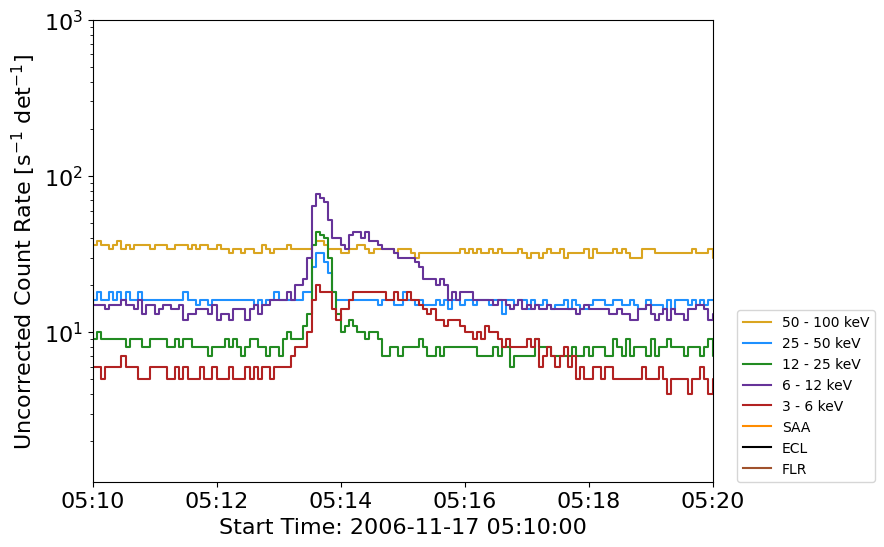

In [11]:
tr=[atime.Time("2006-11-17 05:10:00"),atime.Time("2006-11-17 05:20:00")]
fig,ax = plt.subplots(figsize=(8, 6))
plt.step(times.datetime, countrate[:,4], label=eng_bands[4], where='post',color='goldenrod')
plt.step(times.datetime, countrate[:,3], label=eng_bands[3], where='post',color='dodgerblue')
plt.step(times.datetime, countrate[:,2], label=eng_bands[2], where='post',color='forestgreen')
plt.step(times.datetime, countrate[:,1], label=eng_bands[1], where='post',color='rebeccapurple')
plt.step(times.datetime, countrate[:,0], label=eng_bands[0], where='post',color='firebrick')
ax.set_yscale('log')
ax.set_ylim([1.1,1e3])
ax.set_xlabel('Start Time: '+ tr[0].iso[:-4])
ax.set_ylabel('Uncorrected Count Rate [s$^{-1}$ det$^{-1}$]')
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax.set_xlim([tr[0].datetime,tr[1].datetime])
plt.plot(times.datetime,np.array(saa_flag)*9e2,label='SAA',color='darkorange')
plt.plot(times.datetime,np.array(ecl_flag)*8e2,label='ECL',color='black')
plt.plot(times.datetime,np.array(flr_flag)*7e2,label='FLR',color='sienna')
plt.legend(loc=(1.04,0), prop={'size': 10})
plt.show()

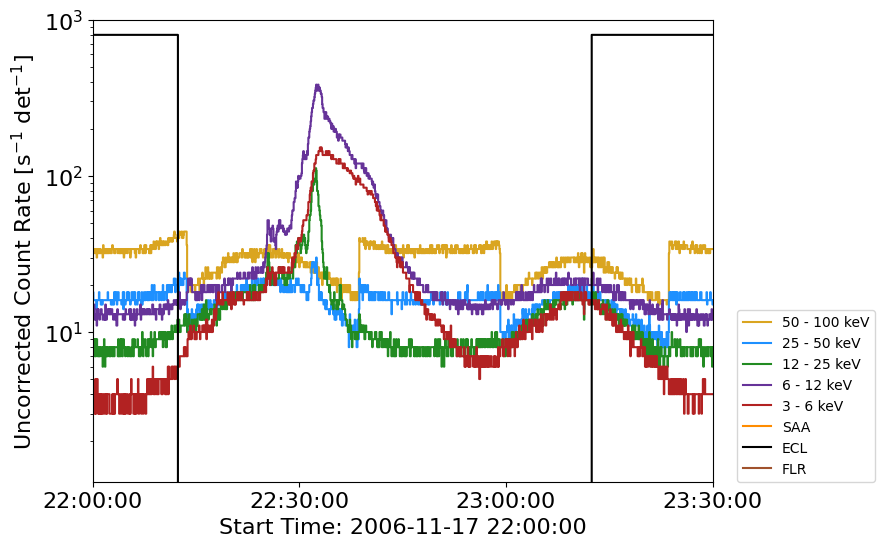

In [12]:
tr=[atime.Time("2006-11-17 22:00:00"),atime.Time("2006-11-17 23:30:00")]
fig,ax = plt.subplots(figsize=(8, 6))
plt.step(times.datetime, countrate[:,4], label=eng_bands[4], where='post',color='goldenrod')
plt.step(times.datetime, countrate[:,3], label=eng_bands[3], where='post',color='dodgerblue')
plt.step(times.datetime, countrate[:,2], label=eng_bands[2], where='post',color='forestgreen')
plt.step(times.datetime, countrate[:,1], label=eng_bands[1], where='post',color='rebeccapurple')
plt.step(times.datetime, countrate[:,0], label=eng_bands[0], where='post',color='firebrick')
ax.set_yscale('log')
ax.set_ylim([1.1,1e3])
ax.set_xlabel('Start Time: '+ tr[0].iso[:-4])
ax.set_ylabel('Uncorrected Count Rate [s$^{-1}$ det$^{-1}$]')
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax.set_xlim([tr[0].datetime,tr[1].datetime])
plt.plot(times.datetime,np.array(saa_flag)*9e2,label='SAA',color='darkorange')
plt.plot(times.datetime,np.array(ecl_flag)*8e2,label='ECL',color='black')
plt.plot(times.datetime,np.array(flr_flag)*7e2,label='FLR',color='sienna')
plt.legend(loc=(1.04,0), prop={'size': 10})
plt.show()

In [13]:
# Flag issue here https://github.com/sunpy/sunkit-instruments/issues/124

flag_reference_time_ut = parse_time(hdulist[14].data.field("UT_REF")[0], format="utime")
flag_time_interval_sec = hdulist[14].data.field("TIME_INTV")[0]
flag_dim = hdulist[14].data.field("N_TIME_INTV")[0]

flag_time_array = parse_time(flag_reference_time_ut) + atime.TimeDelta(
    flag_time_interval_sec * np.arange(flag_dim) * u.second)

# Extract flag arrays
flag_names = hdulist[14].data.field("FLAG_IDS")[0]
saa_flag = hdulist[15].data.field("FLAGS")[:, np.where(flag_names == "SAA_FLAG")[0][0]]
eclipse_flag = hdulist[15].data.field("FLAGS")[:, np.where(flag_names == "ECLIPSE_FLAG")[0][0]]
flare_flag = hdulist[15].data.field("FLAGS")[:, np.where(flag_names == "FLARE_FLAG")[0][0]]

In [14]:
# try another file to see if its flare flags are ok?
hh = read_file('qlook/hsi_obssumm_20040714_126.fits')

# Trying to work out where things are....
# What are the energy bands
eng_bands=[ff+' keV' for ff in hh[5].data[0][7]]

# What are the flag ids and the actual flags
flag_ids=hh[14].data[0][4]
flags=hh[15].data.field("flags")
saa_flag=[ff[0] for ff in flags]
ecl_flag=[ff[1] for ff in flags]
flr_flag=[ff[2] for ff in flags]
att_flag=np.array([ff[14] for ff in flags])
id1=np.where(att_flag ==1)
id3=np.where(att_flag ==3)
dec_wght=[ff[19] for ff in flags]
rear_dec_wght=[ff[29] for ff in flags]

# Need to uncompress the countrate data
comp_cr=hh[6].data["countrate"]
# This still uncorrected for decimation though....
countrate=rhessi.uncompress_countrate(comp_cr)

# And then the times
reference_time_ut = parse_time(hh[5].data.field("UT_REF")[0], format="utime")
time_interval_sec = hh[5].data.field("TIME_INTV")[0]
dim = np.array(countrate[:, 0]).size
times = parse_time(reference_time_ut) + \
    atime.TimeDelta(time_interval_sec * np.arange(dim) * u.second)

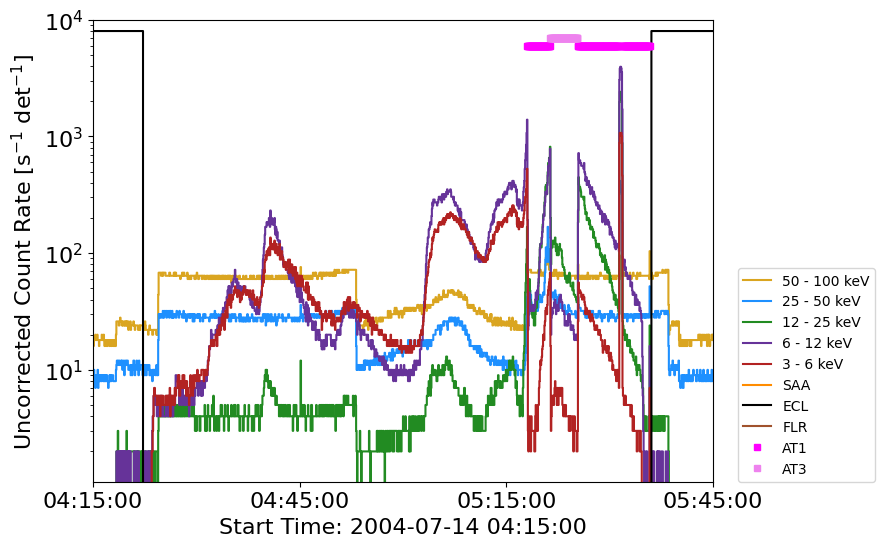

In [15]:
tr=[atime.Time("2004-07-14 04:15:00"),atime.Time("2004-07-14 05:45:00")]
fig,ax = plt.subplots(figsize=(8, 6))
plt.step(times.datetime, countrate[:,4], label=eng_bands[4], where='post',color='goldenrod')
plt.step(times.datetime, countrate[:,3], label=eng_bands[3], where='post',color='dodgerblue')
plt.step(times.datetime, countrate[:,2], label=eng_bands[2], where='post',color='forestgreen')
plt.step(times.datetime, countrate[:,1], label=eng_bands[1], where='post',color='rebeccapurple')
plt.step(times.datetime, countrate[:,0], label=eng_bands[0], where='post',color='firebrick')
ax.set_yscale('log')
ax.set_ylim([1.1,1e4])
ax.set_xlabel('Start Time: '+ tr[0].iso[:-4])
ax.set_ylabel('Uncorrected Count Rate [s$^{-1}$ det$^{-1}$]')
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax.set_xlim([tr[0].datetime,tr[1].datetime])
plt.plot(times.datetime,np.array(saa_flag)*9e3,label='SAA',color='darkorange')
plt.plot(times.datetime,np.array(ecl_flag)*8e3,label='ECL',color='black')
plt.plot(times.datetime,np.array(flr_flag)*7e3,label='FLR',color='sienna')
plt.plot(times[id1].datetime,att_flag[id1]*6e3,label='AT1',color='magenta',marker='s',ls='None',ms=5)
plt.plot(times[id3].datetime,att_flag[id3]*7e3/3,label='AT3',color='violet',marker='s',ls='None',ms=5)
plt.legend(loc=(1.04,0), prop={'size': 10})
plt.show()

In [16]:
def plot_obssumm(filename='qlook/hsi_obssumm_20040714_126.fits',
    trin=["2004-07-14 04:15:00","2004-07-14 05:45:00"],tbin=30):
    hh = read_file(filename)

    # Trying to work out where things are....
    # What are the energy bands
    eng_bands=[ff+' keV' for ff in hh[5].data[0][7]]

    # What are the flag ids and the actual flags
    flag_ids=hh[14].data[0][4]
    flags=hh[15].data.field("flags")
    saa_flag=[ff[0] for ff in flags]
    ecl_flag=[ff[1] for ff in flags]
    flr_flag=[ff[2] for ff in flags]
    att_flag=np.array([ff[14] for ff in flags])
    id1=np.where(att_flag ==1)
    id3=np.where(att_flag ==3)
    dec_wght=[ff[19] for ff in flags]
    rear_dec_wght=[ff[29] for ff in flags]

    # Need to uncompress the countrate data
    comp_cr=hh[6].data["countrate"]
    # This still uncorrected for decimation though....
    countrate=rhessi.uncompress_countrate(comp_cr)

    # And then the times
    reference_time_ut = parse_time(hh[5].data.field("UT_REF")[0], format="utime")
    time_interval_sec = hh[5].data.field("TIME_INTV")[0]
    dim = np.array(countrate[:, 0]).size
    times = parse_time(reference_time_ut) + \
        atime.TimeDelta(time_interval_sec * np.arange(dim) * u.second)

    tr=[atime.Time(trin[0]),atime.Time(trin[1])]
    fig,ax = plt.subplots(figsize=(8, 6))
    plt.step(times.datetime, countrate[:,4], label=eng_bands[4], where='post',color='goldenrod')
    plt.step(times.datetime, countrate[:,3], label=eng_bands[3], where='post',color='dodgerblue')
    plt.step(times.datetime, countrate[:,2], label=eng_bands[2], where='post',color='forestgreen')
    plt.step(times.datetime, countrate[:,1], label=eng_bands[1], where='post',color='rebeccapurple')
    plt.step(times.datetime, countrate[:,0], label=eng_bands[0], where='post',color='firebrick')
    ax.set_yscale('log')
    ax.set_ylim([1.1,1e4])
    ax.set_xlabel('Start Time: '+ tr[0].iso[:-4])
    ax.set_ylabel('Uncorrected Count Rate [s$^{-1}$ det$^{-1}$]')
    ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=tbin))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    ax.set_xlim([tr[0].datetime,tr[1].datetime])
    plt.plot(times.datetime,np.array(saa_flag)*9e3,label='SAA',color='darkorange')
    plt.plot(times.datetime,np.array(ecl_flag)*8e3,label='ECL',color='black')
    plt.plot(times.datetime,np.array(flr_flag)*7e3,label='FLR',color='sienna')
    plt.plot(times[id1].datetime,att_flag[id1]*6e3,label='AT1',color='magenta',marker='s',ls='None',ms=1)
    plt.plot(times[id3].datetime,att_flag[id3]*7e3/3,label='AT3',color='violet',marker='s',ls='None',ms=1)
    plt.legend(loc=(1.04,0), prop={'size': 10})
    plt.show()

        

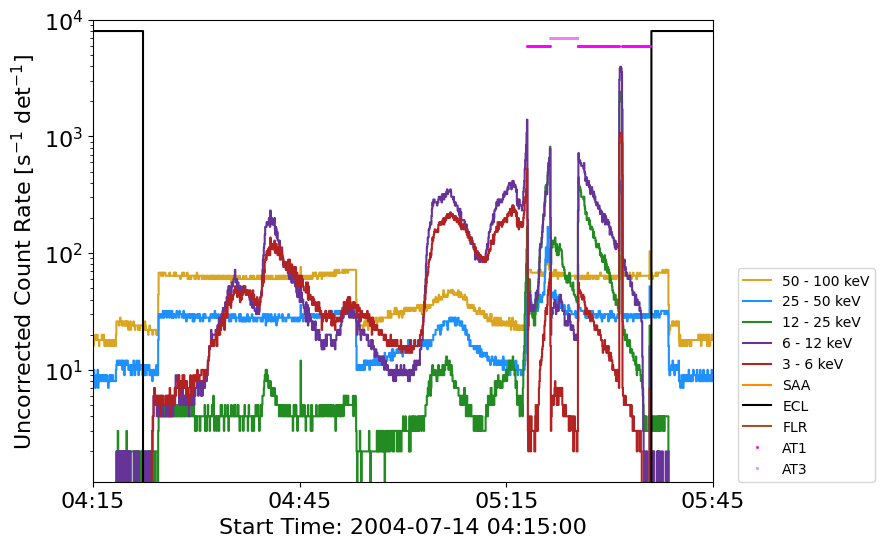

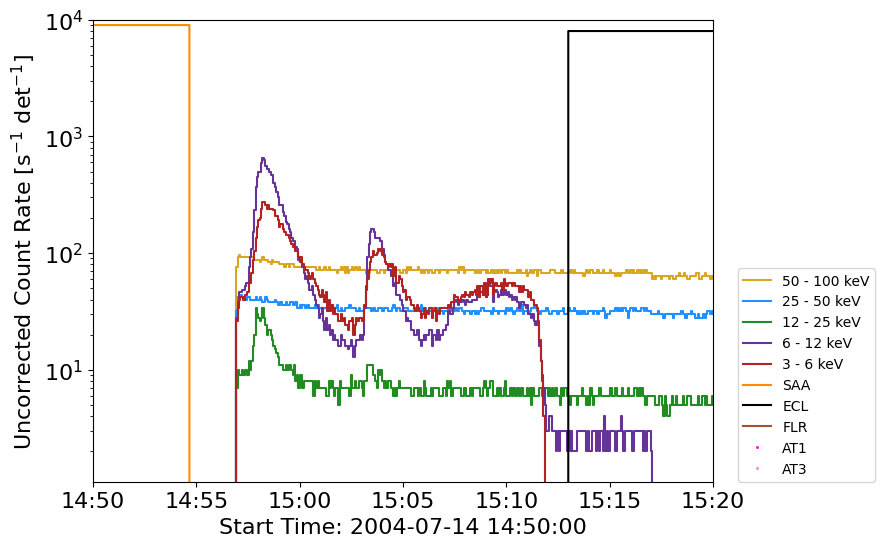

In [17]:
plot_obssumm()
plot_obssumm(trin=["2004-07-14 14:50:00","2004-07-14 15:20:00"],tbin=5)